<a href="https://colab.research.google.com/github/SanjaySaatyaki/pytorch_4_ml_dl/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

classificaiton is predicting where something is one thing or other.(there can be multiple things as options)

In [1]:
import torch
from sklearn.datasets import make_circles

In [2]:
#make 1000 samples
n_samples = 1000

In [3]:
X, y = make_circles(n_samples,noise=0.03,random_state=42)

In [4]:
len(X),len(y)

(1000, 1000)

In [5]:
print(X[:5]),;print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [6]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})

In [7]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


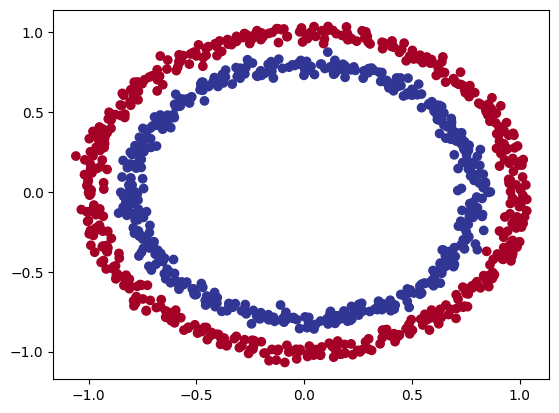

In [8]:
#Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
X_sample = X[0]
y_sample = y[0]
print(f"{X_sample}:{y_sample}")

[0.75424625 0.23148074]:1


In [11]:
### Turn data in tensors and create train and test splits
import torch
torch.__version__

'2.6.0+cu124'

In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
X.dtype

torch.float32

In [14]:
#Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

### Building a model

Lets build a model to classify our blue and red dots

To do so, we want to,
1. Setup device agonistic code so our code will run on a accelerator
2.Construct a model
3.Define a loss function and optimizer
4. Creating a training and test loop

In [16]:
import torch
from torch import nn

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
device

'cpu'

In [19]:
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

- Subclasses `nn.module` (almost all models in Pytorch subclass `nn.module`
- Create 2 `nn.linear()`
- Define `forward()` method that outlines the forward pass

In [20]:
class circle_model_v1(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = circle_model_v1().to(device)

In [21]:
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.3419,  0.1587],
         [ 0.0515,  0.2635],
         [-0.2088,  0.6156],
         [ 0.3334, -0.4283],
         [-0.1676,  0.6252]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3768, -0.2523, -0.4113, -0.0138, -0.6814], requires_grad=True),
 Parameter containing:
 tensor([[ 1.1535e-01,  1.0375e-04, -5.7201e-02, -3.7227e-01,  3.2947e-01]],
        requires_grad=True),
 Parameter containing:
 tensor([0.3621], requires_grad=True)]

In [22]:
model_0

circle_model_v1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)

In [24]:
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
with torch.inference_mode():
  un_trained_preds = model_0(X_test)

In [26]:
len(un_trained_preds), un_trained_preds.shape

(200, torch.Size([200, 1]))

- Regression: MSE or MAE
- Classification: cross entropy or categorical cross entropy

In [27]:
#Setup Loss function
# loss_fn = nn.BCE_Loss() requires to have gone through the sigmoid activation function prior to input to BCE Loss
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [28]:
#Calculate accuracy:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) *100
  return acc

Model outputs are going to be raw **logits**
We can convert these **logists** into prediction probabilities by passing them to some kind of activation function(Sigmoid for binary, Softmax for multiclass)

Convert models's prediction probabilites to **prediction labels** by either round them -Binary or taking argmax()- Multiclass

In [29]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test)[:5]
y_logits

tensor([[-0.6475],
        [-0.6593],
        [-0.3830],
        [-0.7234],
        [-0.0122]])

In [30]:
# Using sigmoid activation function

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3435],
        [0.3409],
        [0.4054],
        [0.3266],
        [0.4969]])

In [31]:
y_pred = torch.round(y_pred_probs)

In [32]:
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device)[:5])))

In [33]:
print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [34]:
torch.manual_seed(42)
epochs = 300

X_train, y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):

  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # loss = loss_fn(torch.signmoid(y_logits),y_train) incase of nn.BCELoss expects predictions probabilites as input
  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true =y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred = test_pred)

  if epoch % 10 == 0:
    print(f"Epoch {epoch}| Train Loss:{loss} | Train acc:{acc:.2f}% | Test loss:{loss} | Test acc:{test_acc:.2f}%")


Epoch 0| Train Loss:0.7163764238357544 | Train acc:41.50% | Test loss:0.7163764238357544 | Test acc:43.50%
Epoch 10| Train Loss:0.7148095965385437 | Train acc:40.38% | Test loss:0.7148095965385437 | Test acc:44.00%
Epoch 20| Train Loss:0.7133790850639343 | Train acc:40.12% | Test loss:0.7133790850639343 | Test acc:44.00%
Epoch 30| Train Loss:0.7120723724365234 | Train acc:42.00% | Test loss:0.7120723724365234 | Test acc:45.50%
Epoch 40| Train Loss:0.7108781933784485 | Train acc:43.75% | Test loss:0.7108781933784485 | Test acc:45.00%
Epoch 50| Train Loss:0.7097859978675842 | Train acc:45.12% | Test loss:0.7097859978675842 | Test acc:46.00%
Epoch 60| Train Loss:0.7087865471839905 | Train acc:45.62% | Test loss:0.7087865471839905 | Test acc:46.50%
Epoch 70| Train Loss:0.7078710198402405 | Train acc:45.62% | Test loss:0.7078710198402405 | Test acc:46.00%
Epoch 80| Train Loss:0.7070320248603821 | Train acc:46.12% | Test loss:0.7070320248603821 | Test acc:46.50%
Epoch 90| Train Loss:0.706262

# Make prediction and evaluvate the model
To inspect lets make visual predictions

In [35]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping downloading")
else:
  print("Download Helper function")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary

Download Helper function


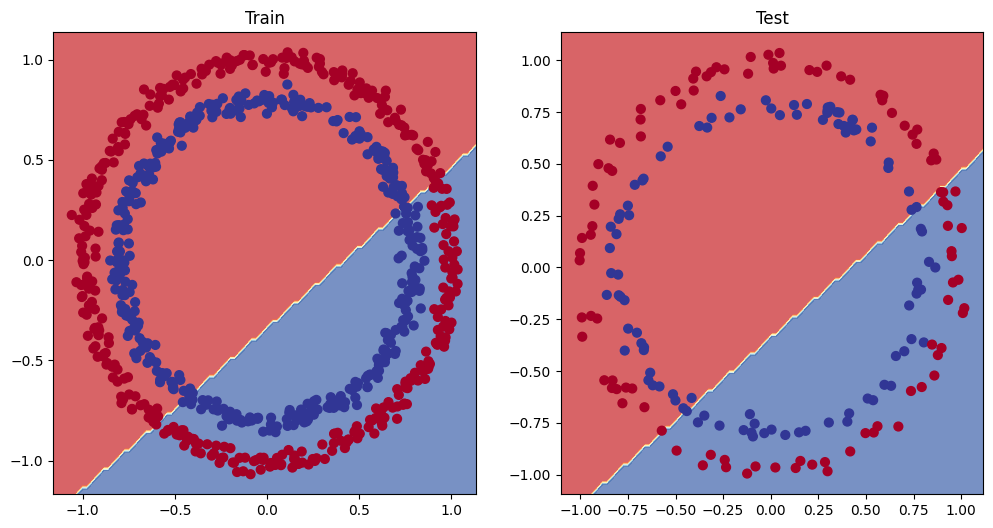

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

# Improving a model
- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for longer
- Changing the activation functions
- Change the learning rate
- Change the loss function

parameters - model updates id
hyperparameter - paramter that user can change

In [37]:
class circle_model_v2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) #Leveraging speeding

In [38]:
model_v2 = circle_model_v2().to(device)
model_v2

circle_model_v2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
#Create loss function
loss_fn1 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_v2.parameters(),lr=0.01)

In [40]:
epochs =1000

for epoch in range(epochs):
  model_v2.train()

  y_logits = model_v2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_v2.eval()
  with torch.inference_mode():
    test_logits = model_v2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}| Loss: {loss:5f}, Acc:{acc:.2f}%, Test Loss: {test_loss:5f}, Test acc: {test_acc:2f}%")

Epoch: 0| Loss: 0.693955, Acc:50.88%, Test Loss: 0.692611, Test acc: 51.000000%
Epoch: 100| Loss: 0.693690, Acc:50.25%, Test Loss: 0.692693, Test acc: 50.000000%
Epoch: 200| Loss: 0.693515, Acc:50.12%, Test Loss: 0.692817, Test acc: 49.500000%
Epoch: 300| Loss: 0.693388, Acc:50.50%, Test Loss: 0.692952, Test acc: 49.000000%
Epoch: 400| Loss: 0.693294, Acc:50.38%, Test Loss: 0.693088, Test acc: 48.500000%
Epoch: 500| Loss: 0.693222, Acc:49.88%, Test Loss: 0.693221, Test acc: 49.500000%
Epoch: 600| Loss: 0.693168, Acc:49.50%, Test Loss: 0.693347, Test acc: 53.000000%
Epoch: 700| Loss: 0.693126, Acc:49.38%, Test Loss: 0.693467, Test acc: 50.500000%
Epoch: 800| Loss: 0.693093, Acc:50.00%, Test Loss: 0.693579, Test acc: 51.000000%
Epoch: 900| Loss: 0.693068, Acc:50.62%, Test Loss: 0.693682, Test acc: 47.500000%


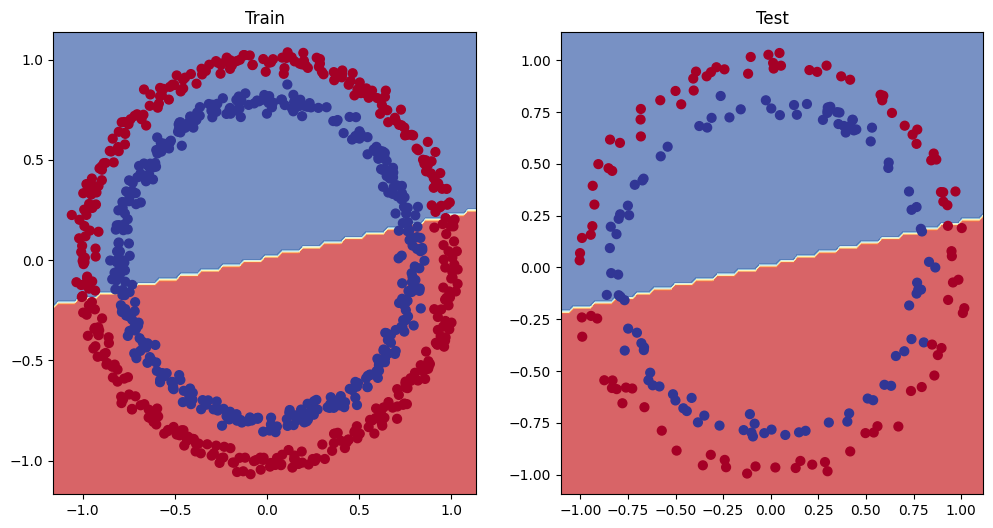

In [41]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_v2,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_v2,X_test,y_test)

## Preparding data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [42]:
weight = 0.7
bias =0.3
start = 0
end =1
step =0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [43]:
train_split = int(0.8 * len(X_regression))

X_train_regression,y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression = X_regression[train_split:],y_regression[train_split:]

In [44]:
from helper_functions import plot_predictions

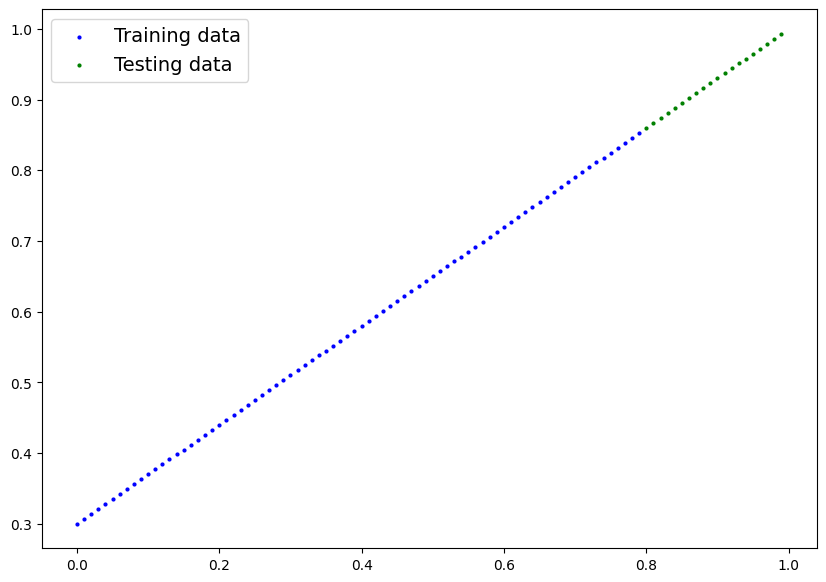

In [45]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)


In [46]:
model_v3 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
)

In [47]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_v3.parameters(),lr=0.1)

In [48]:
epochs = 2000

X_train_regression,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device),y_test_regression.to(device)

In [49]:
for epoch in range(epochs):
  model_v3.train()
  y_pred = model_v3(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_v3.eval()
  with torch.inference_mode():
    test_pred = model_v3(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  if epoch %100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.57896 | Test Loss: 0.47265
Epoch: 100 | Loss: 0.05652 | Test Loss: 0.17491
Epoch: 200 | Loss: 0.05272 | Test Loss: 0.15038
Epoch: 300 | Loss: 0.05733 | Test Loss: 0.14733
Epoch: 400 | Loss: 0.05780 | Test Loss: 0.14758
Epoch: 500 | Loss: 0.04943 | Test Loss: 0.12419
Epoch: 600 | Loss: 0.05283 | Test Loss: 0.14350
Epoch: 700 | Loss: 0.07244 | Test Loss: 0.12574
Epoch: 800 | Loss: 0.04493 | Test Loss: 0.11135
Epoch: 900 | Loss: 0.05377 | Test Loss: 0.13252
Epoch: 1000 | Loss: 0.05325 | Test Loss: 0.14367
Epoch: 1100 | Loss: 0.04654 | Test Loss: 0.10178
Epoch: 1200 | Loss: 0.05776 | Test Loss: 0.13082
Epoch: 1300 | Loss: 0.06252 | Test Loss: 0.12469
Epoch: 1400 | Loss: 0.04877 | Test Loss: 0.11476
Epoch: 1500 | Loss: 0.05837 | Test Loss: 0.13782
Epoch: 1600 | Loss: 0.04967 | Test Loss: 0.13376
Epoch: 1700 | Loss: 0.04334 | Test Loss: 0.13069
Epoch: 1800 | Loss: 0.03799 | Test Loss: 0.13244
Epoch: 1900 | Loss: 0.05011 | Test Loss: 0.11154


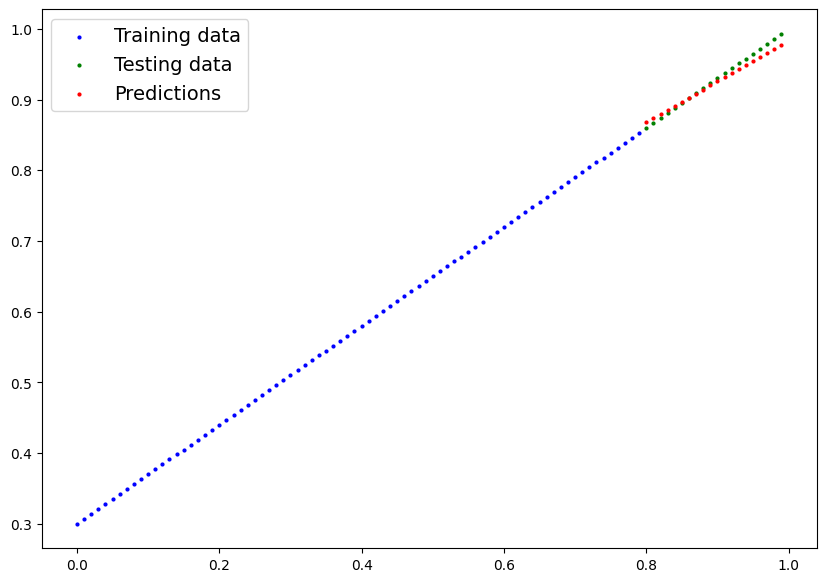

In [50]:
model_v3.eval()
with torch.inference_mode():
  preds = model_v3(X_test_regression)

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=preds)


Non Linearity



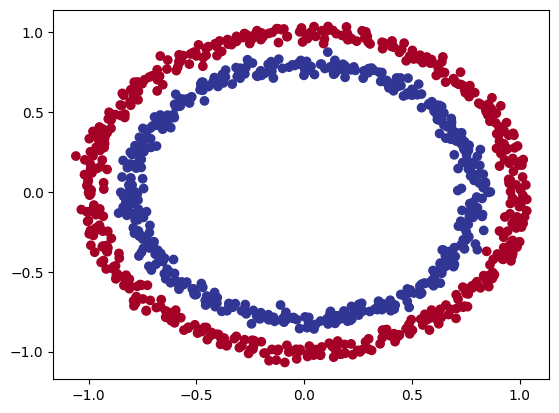

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,noise=0.03,
                    random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [52]:
#Convert data to tensors and then train and test splits

import torch
from sklearn.model_selection import train_test_split

X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [53]:
# Build a model with non linear activation functions
from torch import nn

class circle_model_v3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU() #non linear activation function

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [54]:
model_v4 = circle_model_v3().to(device)
model_v4

circle_model_v3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [55]:
#Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_v4.parameters(),lr=0.1)

In [56]:
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

In [57]:
epoch =1000

for epoch in range(epochs):
  model_v4.train()

  y_logits = model_v4(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true=y_train,y_pred= y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_v4.eval()

  with torch.inference_mode():
    test_logits = model_v4(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,test_pred)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 ==0:
    print(f"Epoch : {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test Loss: {test_loss:.4f} | Test acc:{test_acc:.2f}")


Epoch : 0 | Loss: 0.6928 | Acc: 52.62 | Test Loss: 0.6702 | Test acc:52.00
Epoch : 100 | Loss: 0.6897 | Acc: 52.38 | Test Loss: 0.6744 | Test acc:52.00
Epoch : 200 | Loss: 0.6873 | Acc: 56.38 | Test Loss: 0.6747 | Test acc:55.50
Epoch : 300 | Loss: 0.6839 | Acc: 56.75 | Test Loss: 0.6714 | Test acc:54.50
Epoch : 400 | Loss: 0.6782 | Acc: 61.62 | Test Loss: 0.6666 | Test acc:62.00
Epoch : 500 | Loss: 0.6681 | Acc: 78.50 | Test Loss: 0.6579 | Test acc:78.00
Epoch : 600 | Loss: 0.6489 | Acc: 85.88 | Test Loss: 0.6412 | Test acc:87.00
Epoch : 700 | Loss: 0.6110 | Acc: 91.25 | Test Loss: 0.6083 | Test acc:90.00
Epoch : 800 | Loss: 0.5366 | Acc: 94.12 | Test Loss: 0.5451 | Test acc:94.00
Epoch : 900 | Loss: 0.4122 | Acc: 96.88 | Test Loss: 0.4344 | Test acc:93.50
Epoch : 1000 | Loss: 0.2657 | Acc: 99.50 | Test Loss: 0.2988 | Test acc:97.00
Epoch : 1100 | Loss: 0.2019 | Acc: 97.38 | Test Loss: 0.2197 | Test acc:97.00
Epoch : 1200 | Loss: 0.1089 | Acc: 100.00 | Test Loss: 0.1392 | Test acc:100

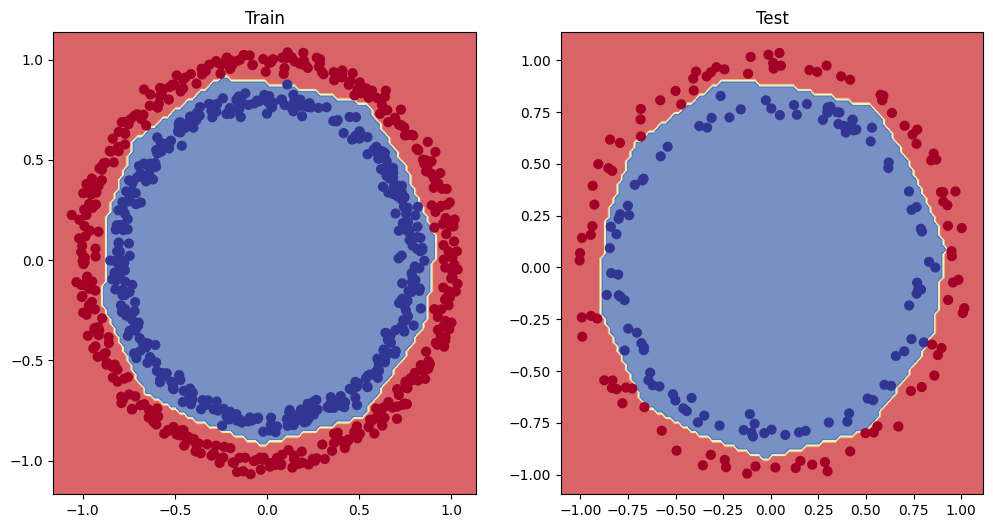

In [58]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_v4,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_v4,X_test,y_test)

Replication non linear activation functions

In [59]:
A = torch.arange(-10,10,1.0)

In [60]:
A.dtype

torch.float32

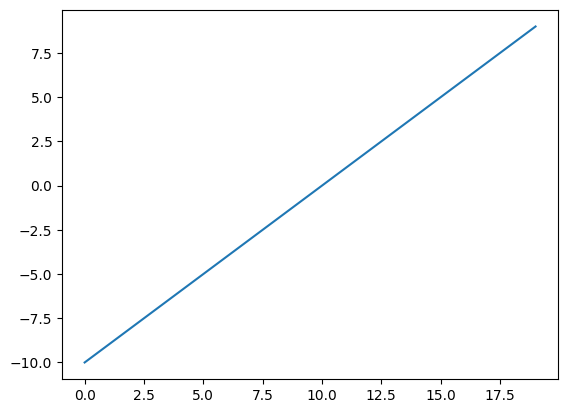

In [61]:
plt.plot(A)

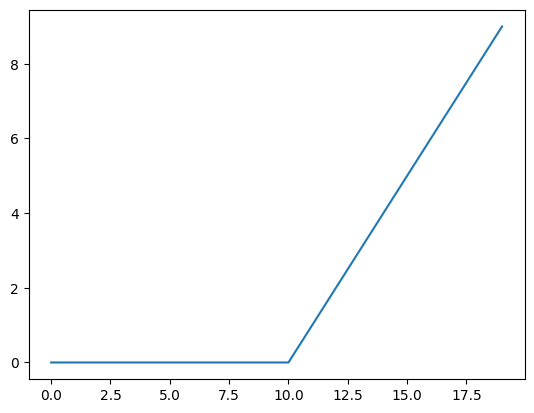

In [62]:
plt.plot(torch.relu(A))

In [63]:
def relu(x: torch.Tensor):
  return torch.maximum(torch.tensor(0),x)

## Putting it all together with multi class classification

- Binary Classification : One thing or another
- Mutli Class Classfication :more than one thing or another (cat vs dog vs chicken)

In [103]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [104]:
NUM_CLASSES = 4
NUM_FEATURES =2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features= NUM_FEATURES, centers = NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

In [105]:
#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test,y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2, random_state=RANDOM_SEED)

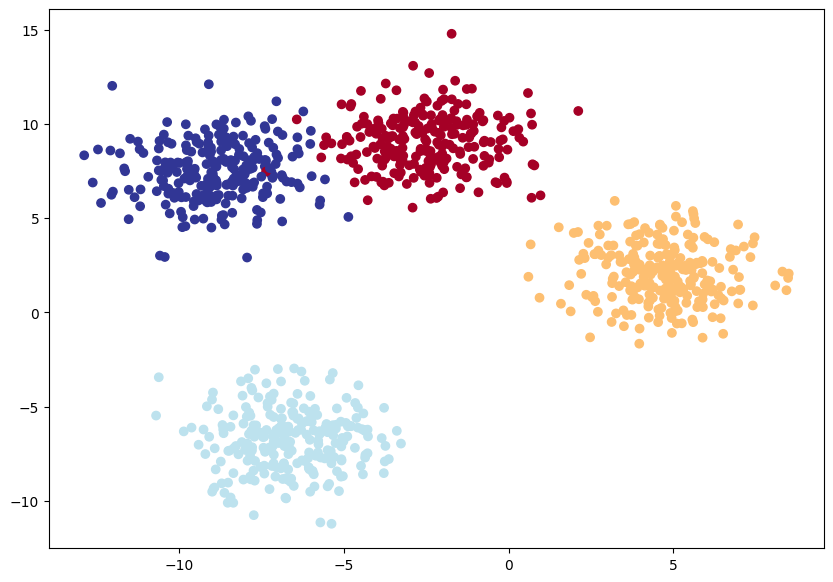

In [106]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

# Hypermeters
- Input layer shape
- Hidden layers
- Neurons per hidden layers
- Output layer shape
- Hidden layer activation
- Output activation
- Loss function
- Optimizer

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [129]:
class blob_model(nn.Module):
  def __init__(self, input_features,output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_v5 = blob_model(input_features=2, output_features=4,hidden_units=8).to(device)


In [130]:
list(model_v5.parameters())

[Parameter containing:
 tensor([[ 0.2797,  0.1899],
         [-0.2756,  0.6033],
         [-0.1021, -0.2753],
         [ 0.4429,  0.5763],
         [ 0.7037,  0.2095],
         [-0.2410,  0.3591],
         [ 0.6067, -0.6936],
         [-0.0876, -0.4822]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1318,  0.2924, -0.1461, -0.0592,  0.3183, -0.1188, -0.5938,  0.5658],
        requires_grad=True),
 Parameter containing:
 tensor([[-1.7795e-01, -3.8841e-02,  3.3349e-02, -2.1247e-02, -3.3258e-01,
           1.6221e-01, -1.6060e-01, -1.8337e-01],
         [ 8.4469e-02, -1.8451e-01, -1.6340e-01, -1.1913e-01, -1.3282e-01,
          -1.4766e-01, -9.5348e-02,  9.1880e-02],
         [-2.8610e-01, -2.1400e-01,  5.1589e-03,  4.9168e-02,  1.9526e-01,
          -2.4835e-01,  1.1285e-01,  2.0096e-01],
         [ 1.9631e-01, -3.2931e-01, -1.3492e-01, -3.0390e-01, -2.2373e-01,
           1.9692e-01, -5.2792e-02,  1.5016e-01],
         [-2.0754e-01,  5.3726e-02, -2.1385e-01,  1.7674e-01, -1.5

In [131]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_v5.parameters(),lr =0.1)

In [132]:
model_v5.eval()
with torch.inference_mode():
  y_logits = model_v5(X_blob_train.to(device))

y_logits[:10]

tensor([[-0.9210, -0.4156,  0.1098, -0.5849],
        [-0.7213,  0.4040, -0.7690,  0.3298],
        [ 3.3210, -0.5497,  1.4233,  1.0620],
        [ 2.1520, -0.3670,  0.8953,  0.7559],
        [-0.2217,  0.2844, -0.4961,  0.4186],
        [-0.9821,  0.1106, -0.5062, -0.0773],
        [-0.5308,  0.5228, -0.8522,  0.5303],
        [-0.6022, -0.4024,  0.1819, -0.4375],
        [ 0.7680,  0.3874, -0.3426,  0.9390],
        [-0.3749,  0.3948, -0.6637,  0.4660]])

In [133]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.9210, -0.4156,  0.1098, -0.5849],
        [-0.7213,  0.4040, -0.7690,  0.3298],
        [ 3.3210, -0.5497,  1.4233,  1.0620],
        [ 2.1520, -0.3670,  0.8953,  0.7559],
        [-0.2217,  0.2844, -0.4961,  0.4186]])
tensor([[0.1458, 0.2416, 0.4086, 0.2040],
        [0.1267, 0.3902, 0.1208, 0.3623],
        [0.7842, 0.0163, 0.1176, 0.0819],
        [0.6201, 0.0499, 0.1765, 0.1535],
        [0.1881, 0.3121, 0.1430, 0.3569]])


In [134]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [135]:
torch.argmax(y_pred_probs[0])

tensor(2)

In [136]:
y_preds = torch.argmax(y_pred_probs,dim=1)

In [137]:
y_preds

tensor([2, 1, 0, 0, 3, 1, 3, 2, 3, 3, 1, 3, 3, 0, 3, 0, 2, 2, 3, 0, 0, 0, 3, 2,
        3, 0, 3, 1, 2, 1, 3, 2, 2, 3, 1, 0, 0, 2, 2, 3, 2, 2, 0, 3, 3, 1, 1, 3,
        2, 1, 3, 3, 0, 1, 2, 2, 3, 1, 0, 0, 3, 2, 1, 0, 2, 3, 0, 0, 0, 2, 1, 0,
        3, 2, 2, 2, 0, 1, 1, 2, 0, 3, 2, 3, 3, 0, 3, 3, 0, 0, 2, 3, 3, 2, 0, 2,
        3, 2, 0, 2, 3, 3, 3, 1, 0, 2, 0, 3, 2, 2, 0, 1, 3, 3, 0, 3, 0, 3, 3, 0,
        3, 3, 0, 0, 3, 2, 0, 1, 3, 3, 0, 3, 0, 2, 3, 2, 2, 2, 2, 3, 3, 2, 1, 0,
        3, 1, 1, 1, 3, 3, 2, 3, 3, 1, 3, 0, 0, 1, 1, 3, 3, 3, 3, 3, 1, 0, 3, 2,
        0, 0, 0, 3, 1, 2, 2, 1, 2, 0, 3, 3, 0, 2, 3, 0, 3, 3, 3, 2, 2, 0, 0, 0,
        0, 0, 0, 3, 3, 3, 0, 1, 2, 0, 3, 2, 1, 1, 2, 3, 1, 2, 3, 3, 0, 3, 3, 3,
        2, 1, 3, 2, 1, 3, 0, 2, 3, 0, 1, 1, 3, 2, 1, 2, 1, 0, 0, 1, 3, 3, 3, 0,
        1, 0, 1, 3, 2, 3, 1, 0, 0, 1, 2, 2, 3, 0, 2, 2, 2, 1, 2, 3, 2, 2, 1, 0,
        0, 3, 2, 1, 2, 0, 3, 2, 0, 1, 3, 2, 0, 3, 3, 1, 3, 3, 3, 0, 3, 3, 2, 1,
        0, 0, 0, 0, 3, 2, 0, 0, 1, 0, 3,

Logits -> Prediction Probabilites (torch.softmax) -> Prediction labels(torch.argmax)

In [138]:
epochs = 100

for epoch in range(epochs):
  model_v5.train()

  y_logits = model_v5(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,y_pred=y_pred)
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_v5.eval()
  with torch.inference_mode():
    test_logits = model_v5(X_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,y_pred = test_preds)

  if epoch % 10 ==0:
    print(f"Epoch {epoch} | Train Loss: {loss:.5f} | Acc: {acc:.2f}% |Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch 0 | Train Loss: 1.59686 | Acc: 23.38% |Test Loss: 0.59682 | Test Acc: 72.50%
Epoch 10 | Train Loss: 0.15733 | Acc: 98.38% |Test Loss: 0.13235 | Test Acc: 99.50%
Epoch 20 | Train Loss: 0.08384 | Acc: 99.12% |Test Loss: 0.07534 | Test Acc: 99.50%
Epoch 30 | Train Loss: 0.06175 | Acc: 99.00% |Test Loss: 0.05408 | Test Acc: 99.50%
Epoch 40 | Train Loss: 0.05103 | Acc: 99.00% |Test Loss: 0.04339 | Test Acc: 99.50%
Epoch 50 | Train Loss: 0.04481 | Acc: 99.00% |Test Loss: 0.03703 | Test Acc: 99.50%
Epoch 60 | Train Loss: 0.04079 | Acc: 99.00% |Test Loss: 0.03282 | Test Acc: 99.50%
Epoch 70 | Train Loss: 0.03800 | Acc: 99.00% |Test Loss: 0.02985 | Test Acc: 99.50%
Epoch 80 | Train Loss: 0.03596 | Acc: 99.00% |Test Loss: 0.02763 | Test Acc: 99.50%
Epoch 90 | Train Loss: 0.03442 | Acc: 99.00% |Test Loss: 0.02591 | Test Acc: 99.50%


In [139]:
model_v5.eval()
with torch.inference_mode():
  y_logits = model_v5(X_blob_test)
y_logits[:10]

tensor([[  3.5083,   9.4346, -13.7398,  -9.9910],
        [  5.3881, -11.6029,   3.6284,  11.0028],
        [ -5.3990, -13.4303,  21.9519,  13.4753],
        [  1.0989,   6.6643,  -7.3728,  -7.0690],
        [  7.7071,   2.9965, -13.9886,  -3.7809],
        [  6.1265, -14.3146,   5.1054,  13.6794],
        [ -5.9608, -10.4837,  19.9776,  10.5525],
        [  6.9008,  -0.8724,  -9.0256,   0.1482],
        [ -5.1238, -18.3760,  26.2911,  18.4206],
        [  7.0668,   0.5339, -10.6345,  -1.2725]])

In [141]:
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[2.6612e-03, 9.9734e-01, 8.5965e-11, 3.6510e-09],
        [3.6284e-03, 1.5158e-10, 6.2447e-04, 9.9575e-01],
        [1.3230e-12, 4.3013e-16, 9.9979e-01, 2.0823e-04],
        [3.8136e-03, 9.9618e-01, 7.9816e-07, 1.0816e-06],
        [9.9107e-01, 8.9188e-03, 3.7479e-10, 1.0161e-05],
        [5.2418e-04, 6.9512e-13, 1.8881e-04, 9.9929e-01],
        [5.4333e-12, 5.8989e-14, 9.9992e-01, 8.0664e-05],
        [9.9841e-01, 4.2020e-04, 1.2094e-07, 1.1660e-03],
        [2.2725e-14, 3.9915e-20, 9.9962e-01, 3.8169e-04],
        [9.9831e-01, 1.4523e-03, 2.0496e-08, 2.3853e-04]])

In [142]:
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

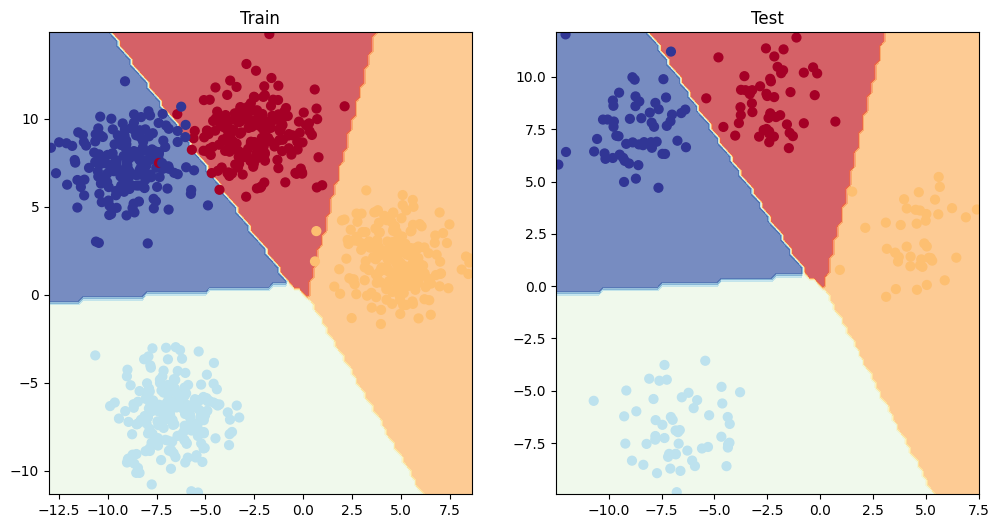

In [144]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_v5,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_v5,X_blob_test,y_blob_test)